# Tutorial: Banchmarking DADApy on Möbius strip data

In this tutorial we will compare some of DADApy key methods with other approaches usig a symthetic dataset consisting of 8 clusters lying on a 2D space, twisted to form a 3D Möbius strip, and embedded in a noisy 50D space.

In [1]:
# load necessary modules and plot functions.

import numpy as np
import matplotlib.pyplot as plt
from dadapy import Data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Import a test data set and plot it

In [2]:
# We will employ the two dimensional datasets from (d'Errico et al., Information Sicences, 2021)
# twisted to form a three dimensional Mobius strip

idx = np.arange(20000)
#N = 20000 # choose N < 20000 for a quicker run
#idx = np.random.choice(np.arange(20000), size = N, replace=False)

dd = np.loadtxt('datasets/Fig1_mobius.dat')[idx]
d2 = np.loadtxt('datasets/Fig1.dat')[idx]
gt = np.loadtxt('datasets/gt_F1.txt')[idx]
n_clus = int(gt.max()+1)
print('number of clusters: ',n_clus)

number of clusters:  8


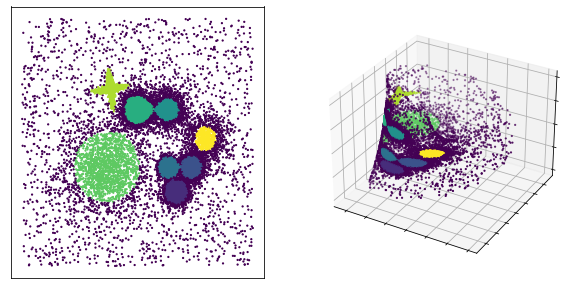

In [3]:
fig = plt.figure(figsize=(10, 5))

# Original 2D data
ax = fig.add_subplot(1, 2, 1)
ax.scatter(*d2.T,c=gt,s=1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(True)

# 3D Mobius embedding
ax = fig.add_subplot(1, 2, 2, projection='3d')
x=dd[:,0]
y=dd[:,1]
z=dd[:,2]
ax.scatter(x,y,z,c=gt,s=1.5)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

### Embed in 50 dimensions

In [4]:
rng = np.random.default_rng(0)
D = 50
eps = 1e-2
ext = rng.uniform(-eps,eps,size=(len(dd),D-3))
dd = np.hstack([dd,ext])
print(dd.shape)

(20000, 50)


In [5]:
from scipy.stats import special_ortho_group

In [6]:
np.random.seed(11)
R = special_ortho_group.rvs(D)
dd = np.dot(dd,R)
print(dd.shape)

(20000, 50)


## Using DADApy on the dataset: Intrinsic dimension, density estimation and clustering

We here apply a typical pipeline to follow when analyzing the data. 
The task consists in obtaining an accurate description of the clusters present in the data and of their hierarchies. 

In [7]:
# initialize the Data class from the DADApy module. We set the verbose mode so we can follow all the steps.
data = Data(dd, verbose=True)

In [8]:
# compute distances up to the maxk NN
data.compute_distances(maxk = 1000)

Computation of distances started
Computation of the distances up to 1000 NNs started
7.15 seconds for computing distances


### Estimate the Intrinsic Dimension

In [9]:
data.compute_id_2NN()

ID estimation finished: selecting ID of 20.051368550352585


(20.051368550352585, 0.0, 0.05237625769800649)

In [10]:
a,b,c = data.return_id_scaling_2NN()

ID estimation finished: selecting ID of 20.051368550352585
ID estimation finished: selecting ID of 17.29757368833606
ID estimation finished: selecting ID of 14.870245099902727
ID estimation finished: selecting ID of 12.202288222922789
ID estimation finished: selecting ID of 9.609930053523575
ID estimation finished: selecting ID of 7.438865976156046
ID estimation finished: selecting ID of 5.852638189769335
ID estimation finished: selecting ID of 4.754227455396497
ID estimation finished: selecting ID of 3.685567533854301
ID estimation finished: selecting ID of 3.0111789272873812
ID estimation finished: selecting ID of 2.6205952645150576


In [11]:
a1,b1,c1 = data.return_id_scaling_gride(range_max=1024)

distance not computed up to 1024. distance computation started
distance computation finished
id inference started
id inference finished


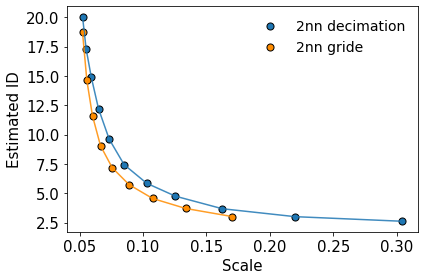

In [12]:
col = 'darkorange'
plt.plot(c,a,alpha=0.85)
plt.errorbar(c,a,b,fmt='None')
plt.scatter(c,a,edgecolors='k',s=50,label='2nn decimation')
plt.plot(c1,a1,alpha=0.85,color=col)
plt.errorbar(c1,a1,b1,fmt='None',color=col)
plt.scatter(c1,a1,edgecolors='k',color=col,s=50,label='2nn gride')
plt.xlabel(r'Scale',size=15)
plt.ylabel('Estimated ID',size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(frameon=False,fontsize=14)
plt.tight_layout()

### Estimate the density

In [13]:
data.set_id(2)
data.compute_density_PAk()

kstar estimation started, Dthr = 23.92812698
1.82 seconds computing kstar
PAk density estimation started
15.19 seconds optimizing the likelihood for all the points
PAk density estimation finished


(array([-0.38, -3.32, -4.27, ..., -5.69, -5.31, -5.49]),
 array([0.09, 0.22, 0.23, ..., 0.52, 0.34, 0.27]))

### Advanced Density Peaks (ADP)

In [14]:
data.compute_clustering_ADP(Z = 1.5, halo=True)
print('number of clusters found: ', len(data.cluster_centers))

Clustering started
init succeded
part one finished: Raw identification of the putative centers
part two finished: Further checking on centers
part tree finished: Pruning of the centers wrongly identified in part one.
('Number of clusters before multimodality test=', 14)
1001
0.20 seconds clustering before multimodality test
0.10 seconds identifying the borders
0.00 seconds with multimodality test
0.00 seconds for final operations
Clustering finished, 8 clusters found
total time is, 0.42092299461364746
number of clusters found:  8


### Compute Adjusted Mutual Information score for the cluster assignment

In [15]:
from sklearn.metrics.cluster import adjusted_mutual_info_score as ami

In [16]:
MI_adp = ami(data.cluster_assignment,gt)
print(MI_adp)

0.7215415826641608


([], [])

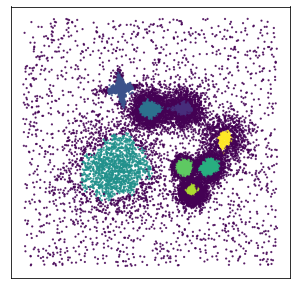

In [17]:
plt.figure(figsize=(5,5))
plt.scatter(*d2.T,c=data.cluster_assignment,s=1.5,alpha=0.75)
plt.xticks([])
plt.yticks([])

Moreover, the method provides a measure of the hierarchical relationships among clusters. Following the original paper, we have three ways for visualizing these relationships: 
As a *dendrogram*, as a *2D multidimensional scaling projection* and as a *matrix*.   

#### Dendrogram obtention and interpretation

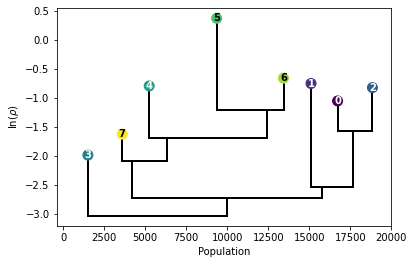

In [18]:
get_dendrogram(data,logscale=False,cmap="viridis")

The dendrogram is a classic way of visualizing hierarchies. The height of the points correspond to the log_den
value of the cluster center, and the value on the y-axis of the connections corresponds to the log_den at the 
border between clusters. To encode more information, the space around each point is proportional to the cluster
population (or its logarithm if the logscale variable is set to True).

### 2D multidimensional scaling obtention and interpretation

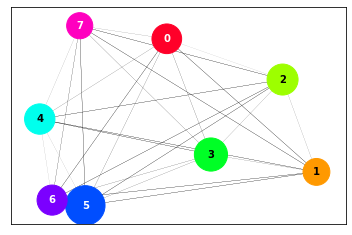

In [19]:
plot_MDS(data,cmap='gist_rainbow')

This projection allows to see the similarity relationships among clusters, based on the principle that the higher is the density of points at the border between clusters, the more similar they are. The size of the cluster circle is proportional to its population and the distances between circles and the widths of the lines connecting them are proportional to the density at the borders between clusters.  

#### Matrix obtention and interpretation

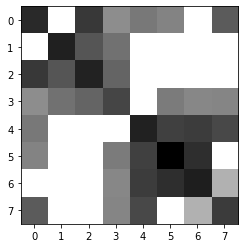

In [20]:
plot_matrix(data)

This is a direct visualization of the key densities resulting from the clustering. It is matrix plot in gray scale, where the darkest the square, the higher the density. The diagonal points correspond to the center of the cluster while the off-diagonal correspond to the density at the border.  

## Comparison with other clustering techniques

In [21]:
MI = []
MI_labels = []

### Kmeans

In [22]:
from sklearn.cluster import KMeans

In [24]:
C = 20
cost = []
MI_kmeans = []
for num_clusters in range(1,C):
    print(num_clusters,end='\r')
    kmeans = KMeans(n_clusters=num_clusters, init = 'k-means++', n_init = 10, verbose=False)
    kmeans.fit_predict(dd)
    cost.append(kmeans.inertia_)
    MI_kmeans.append(ami(gt,kmeans.labels_))

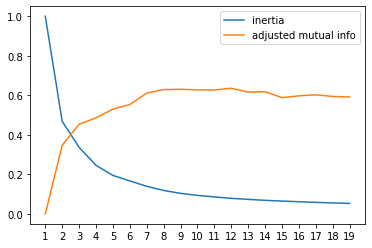

In [25]:
plt.plot(range(1,C),np.array(cost)/cost[0],label='inertia')
plt.plot(range(1,C),MI_kmeans,label='adjusted mutual info')
plt.xticks(range(1,C))
plt.legend()

what would you choose if you didn't have the ground truth assigmement?

#### lets look at the assignement with right amount of clusters

In [26]:
kmeans = KMeans(n_clusters=n_clus, init = 'k-means++', n_init = 10, verbose=False)
kmeans.fit_predict(dd);

([], [])

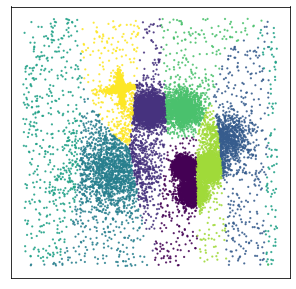

In [27]:
plt.figure(figsize=(5,5))
plt.scatter(*d2.T,c=kmeans.labels_,s=1.5,alpha=0.75)
plt.xticks([])
plt.yticks([])

In [28]:
MIi = ami(gt,kmeans.labels_)
print(MIi)

0.6291537816500119


In [29]:
MI_labels.append('kmeans')
MI.append(MIi)

### Spectral clustering

In [30]:
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(n_clusters=n_clus, n_jobs=2)
spectral_clustering.fit(dd)

SpectralClustering(n_jobs=2)

In [31]:
MIi = ami(gt,spectral_clustering.labels_)
print(MIi)

0.2183694250635406


In [32]:
MI.append(MIi)
MI_labels.append('SC')

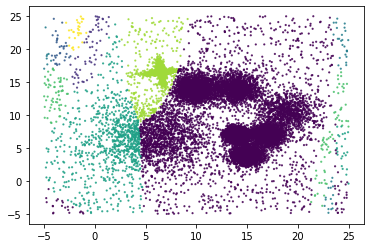

In [33]:
%matplotlib inline
plt.scatter(*d2.T,c=spectral_clustering.labels_,s=1.5,alpha=0.75)
plt.show()

### Dbscan

In [34]:
from sklearn.cluster import DBSCAN

In [35]:
dbscan = DBSCAN(eps=0.05,min_samples=20)
dbscan.fit(dd)
print(dbscan.labels_.max()+1)

7


In [36]:
MIi = ami(gt,dbscan.labels_)
print(MIi)

0.25414367126158843


In [37]:
MI.append(MIi)
MI_labels.append('DBSCAN')

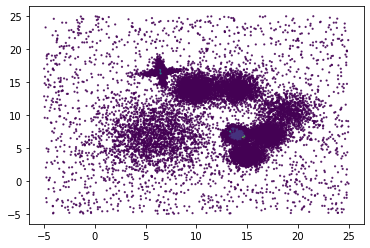

In [38]:
plt.scatter(*d2.T,c=dbscan.labels_,s=1.5,alpha=0.75)

### Hdbscan

In [39]:
import hdbscan

In [40]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20,min_samples=20)
clusterer.fit(dd)
print(clusterer.labels_.max()+1)

8


In [41]:
MIi = ami(gt,clusterer.labels_)
print(MIi)

0.5785816410430946


In [42]:
MI_labels.append('HDBSCAN')
MI.append(MIi)

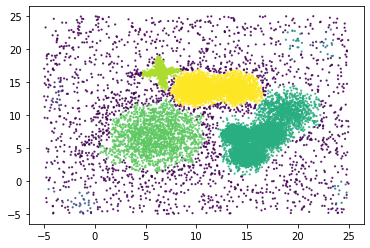

In [43]:
plt.scatter(*d2.T,c=clusterer.labels_,s=1.5,alpha=0.75)

### add adp

In [44]:
MI_labels.append('ADP')
MI.append(MI_adp)

### Plot Summary

In [45]:
print(MI_labels,MI)

['kmeans', 'SC', 'DBSCAN', 'HDBSCAN', 'ADP'] [0.6291537816500119, 0.2183694250635406, 0.25414367126158843, 0.5785816410430946, 0.7215415826641608]


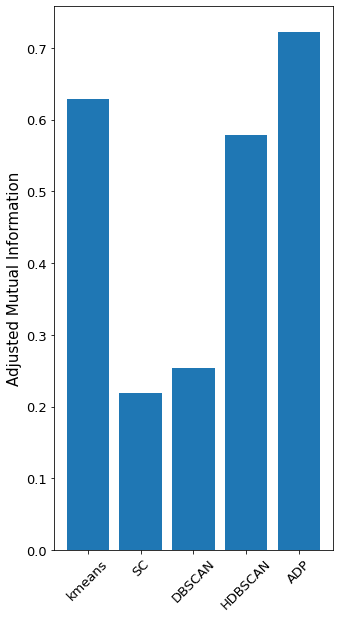

In [46]:
plt.figure(figsize=(5,10))
plt.bar(MI_labels,MI)
plt.xticks(size=13,rotation=45,ha='center')
plt.yticks(size=13)
plt.ylabel('Adjusted Mutual Information',size=15)

## Performance of projection methods

### PCA

In [47]:
from sklearn.decomposition import PCA

([], [])

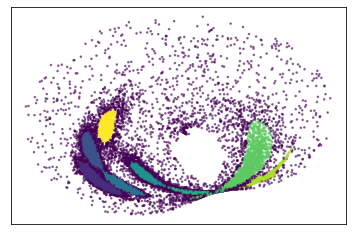

In [48]:
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(dd)
plt.scatter(pca_emb[:,0],pca_emb[:,1],alpha=0.5,s=2.5,c=gt)
plt.xticks([])
plt.yticks([])

### Isomap

In [49]:
from sklearn.manifold import Isomap

In [50]:
# warning: this might take long! (roughly 5-10 minutes)
isomap = Isomap(n_components=2, n_neighbors=15)
isomap_emb = isomap.fit_transform(dd)

([], [])

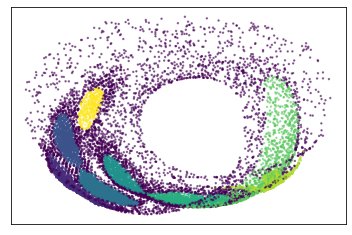

In [51]:
plt.scatter(*isomap_emb.T,alpha=0.5,s=2,c=gt)
plt.xticks([])
plt.yticks([])